Reproduce the ERA5 precipitation anomaly maps for each WT 
NPL_2022b

In [1]:
import datetime
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import glob 
import os.path
import cartopy 
import cartopy.crs as ccrs
import cartopy.feature as cfeature

daily precipitation data is from previous ncl code hourly data to daily data:
prec_us_era5.ncl  <br>
prec_us_era5_daily.ncl <br>

weather types are from <br>
/glade/campaign/mmm/c3we/mingge/ERA_INTERIM/WT  <br>
Produced by: AssignToExistingWTs_ERA_INTERIM.ipynb

In [2]:
level_s = np.array([0, 1, 2.5, 5, 7.5, 10, 15, 20,25, 37.5, 50,
         75, 100, 125, 150, 200, 250, 300, 400, 500, 600, 750])

proj = ccrs.PlateCarree()

def ax_coastlines_country(ax_s):
    ax_s.coastlines(linewidths=0.5)
    ax_s.add_feature(cfeature.NaturalEarthFeature(category='cultural',
                                           name='admin_0_countries',
                                           scale='10m',
                                           facecolor='none',
                                           edgecolor='black',
                                           linewidth=0.2))
 
def plot_prec_12(prec, min_v, max_v, n_lev, cmap_s, colorbar_ori, title_s):
    '''
    prec(12,nlat, nlon): 3d variable to plot
    colorbar_ori: colorbar orientation, verticle or horizontal
    title_s: the common title for subplot
    '''
    fig = plt.figure(figsize=(18,14))
    
    cnlevel = np.linspace(min_v, max_v, num=n_lev)
  
    for col in range(12):
        ax_s = plt.subplot(4, 3, col+1, projection=proj)
        ax_coastlines_country(ax_s)
        ax_s.add_feature(cfeature.STATES, linestyle=':')
        ax_s.add_feature(cartopy.feature.OCEAN,zorder=100, edgecolor='k')
 
        mem = col + 1

        im=prec[col].plot.contourf(
            levels=cnlevel,
            cmap=cmap_s,
            ax=ax_s,
            transform=proj,
            add_colorbar=False)
        
        plt.title('WT' + str(mem),fontweight="bold", size=15)

    # single title for All the Subplot
    fig.suptitle('member: ' + title_s, fontweight="bold", fontsize=30)
    
    fig.tight_layout()
    # The position of the bottom edge of the subplots, as a fraction of the figure height.
    #fig.subplots_adjust(bottom=0.15)

    #rect [left, bottom, width, height]
    #cbar_ax = fig.add_axes([0.2, 0.1, 0.7, 0.03])
    #fig.colorbar(im, cax=cbar_ax,orientation='horizontal')
    if colorbar_ori=="vertical":
        #rect [left, bottom, width, height]
        cbar_ax = fig.add_axes([0.99, 0.1, 0.04, 0.8])
    else:
        #rect [left, bottom, width, height]
        cbar_ax = fig.add_axes([0.2, 0.001, 0.7, 0.03])
    
    fig.colorbar(im, cax=cbar_ax, orientation=colorbar_ori)
        

In [3]:
# centroid_ana.ibynb, wt_hist_smyle_era5.ipynb
sCentroids='/glade/u/home/mingge/WTing_existing-centroids/CONUS-WTs_existing_centroids.npz'
DATA=np.load(sCentroids)
rgrCentroids=DATA['rgrCentroids']               # (12, 3, 24, 74)
rgiWTs=range(1, rgrCentroids.shape[0]+1, 1)     # number of WT 

lat_s = DATA['rgrLatWT'].min() - 6
lat_e = DATA['rgrLatWT'].max() + 2
lon_s = DATA['rgrLonWT'].min() + 360 
lon_e = DATA['rgrLonWT'].max() + 360 + 6
print('lat:', lat_s , '-', lat_e, 'lon:', lon_s, '-', lon_e)

lat: 24.75 - 50.0 lon: 234.75 - 295.5


In [4]:
dir_era5 = '/glade/work/mingge/ERA5/'
dir_wt = '/glade/campaign/mmm/c3we/mingge/COEXIST/ERA5/WT_1979-2021/'

In [5]:
flnm = dir_era5 + 'prec_200104_daily.nc'
with  xr.open_dataset(flnm) as ds_prec:
    print(ds_prec)

<xarray.Dataset>
Dimensions:    (day: 30, latitude: 97, longitude: 238)
Coordinates:
  * latitude   (latitude) float64 25.0 25.25 25.5 25.75 ... 48.5 48.75 49.0
  * longitude  (longitude) float64 234.8 235.0 235.2 235.5 ... 293.5 293.8 294.0
Dimensions without coordinates: day
Data variables:
    lsp        (day, latitude, longitude) float32 ...
    cp         (day, latitude, longitude) float32 ...
Attributes:
    history:      From: /glade/work/mingge/ERA5/prec_200104.nc
    description:  daily ERA5 precipitation over U.S.
    script:       Ming Ge: prec_us_era5_daily.ncl


#### calculate prec climatology

In [6]:
year_s = 1979
year_e = 2019

flnm_nc = '/glade/campaign/mmm/c3we/mingge/COEXIST/ERA5/prec_clim_1979-2019.nc'

if os.path.isfile(flnm_nc):
    print(flnm_nc, 'exist')
    with  xr.open_dataset(flnm_nc) as ds_prec:
        prec_mean = ds_prec.__xarray_dataarray_variable__
        
else:  
    is_first = True
    for year in range(year_s, year_e+1, 1):
        for month in range(1,13,1):
            mon_s = str(month).zfill(2)
            flnm = dir_era5 + 'prec_' + str(year) + mon_s + '_daily.nc'
            print(flnm)
            with  xr.open_dataset(flnm) as ds:
                prec = ds.cp.sel(latitude=slice(lat_s, lat_e), longitude=slice(lon_s, lon_e)).mean(dim='day') \
                     + ds.lsp.sel(latitude=slice(lat_s, lat_e),longitude=slice(lon_s, lon_e)).mean(dim='day')
                #print(prec)
                
            if is_first == True:
                data_all = prec.copy()
                is_first = False
            else:
                data_all = xr.concat([data_all, prec], dim='day')
                           
    print(data_all.shape)
    # m->mm 
    prec_mean = data_all.mean(dim='day')*1000.
    prec_mean.attrs['units'] = 'mm/day'
    prec_mean.to_netcdf( path = flnm_nc)    

/glade/campaign/mmm/c3we/mingge/COEXIST/ERA5/prec_clim_1979-2019.nc exist


#### precipitation anomalies of WTs

In [21]:
n_wt  = 12

n_lat = prec_mean.shape[0]
n_lon = prec_mean.shape[1]

prec_3d = np.zeros((n_wt, n_lat, n_lon))

flnm_prec = '/glade/campaign/mmm/c3we/mingge/COEXIST/ERA5/prec_ano.nc'
if os.path.isfile(flnm_prec):
    print(flnm_prec, 'exist')
    with  xr.open_dataset(flnm_prec) as ds:
        prec_xr = ds.__xarray_dataarray_variable__
else:
  for nw in range(n_wt):
    print(nw+1)
    is_first = True
    for year in range(year_s, year_e+1, 1):
        StartDay = datetime.datetime(year,  1, 1,  0)
        EndDay   = datetime.datetime(year, 12, 31,  0)
        TimeDD   = pd.date_range(StartDay, EndDay, freq='d')
                 
        # read WT file
        flnm_wt = dir_wt + 'CONUS-WTs_' + str(year) +'.cla'
        #print(flnm_wt)
            
        wts = pd.read_csv(flnm_wt, delimiter = '\t', header=None,  names=["year", "month", "day", "wt"])
        wts_g = wts.groupby(['wt']) 
        g_ind = wts_g.get_group(nw+1).index
            
        # concatenate monthly data to annual data
        for month in range(1,12+1,1):
            mon_s = str(month).zfill(2)
            flnm = dir_era5 + 'prec_' + str(year) + mon_s + '_daily.nc'
            #print(flnm)
         
            with xr.open_dataset(flnm) as ds:
                prec = ds.cp.sel(latitude=slice(lat_s, lat_e), longitude=slice(lon_s, lon_e)) \
                     + ds.lsp.sel(latitude=slice(lat_s, lat_e),longitude=slice(lon_s, lon_e))
                if month == 1:
                    prec_annual = prec.copy()
                else:
                    prec_annual = xr.concat([prec_annual, prec.copy()], dim='day')
                 
        #print(prec_annual.shape)
        prec_wt = prec_annual[g_ind,:,:]
        # check time coordinates associated with WT
        #print(prec_wt)
                
        if is_first == True:
            data_all = prec_wt.copy()
            is_first = False
        else:
            data_all = xr.concat([data_all, prec_wt.copy()], dim='day')
            #print(data_all.shape)
    print(data_all.shape)                
    prec_3d[nw] = (data_all.mean("day")*1000 - prec_mean)/prec_mean*100
     
  prec_xr = xr.DataArray(prec_3d, 
                       coords={'lat':prec_mean.latitude.values, 'lon': prec_mean.longitude.values, 'wt':range(n_wt)},
                       dims=['wt', 'lat', 'lon'])
  prec_xr.attrs['units'] = '%'
  prec_xr.to_netcdf(path = flnm_prec)             
  print(flnm_prec) 

/glade/campaign/mmm/c3we/mingge/COEXIST/ERA5/prec_ano.nc exist


#### ensemble average precipitation anomaly maps for each WT

https://www.frontiersin.org/articles/10.3389/fenvs.2019.00036/full

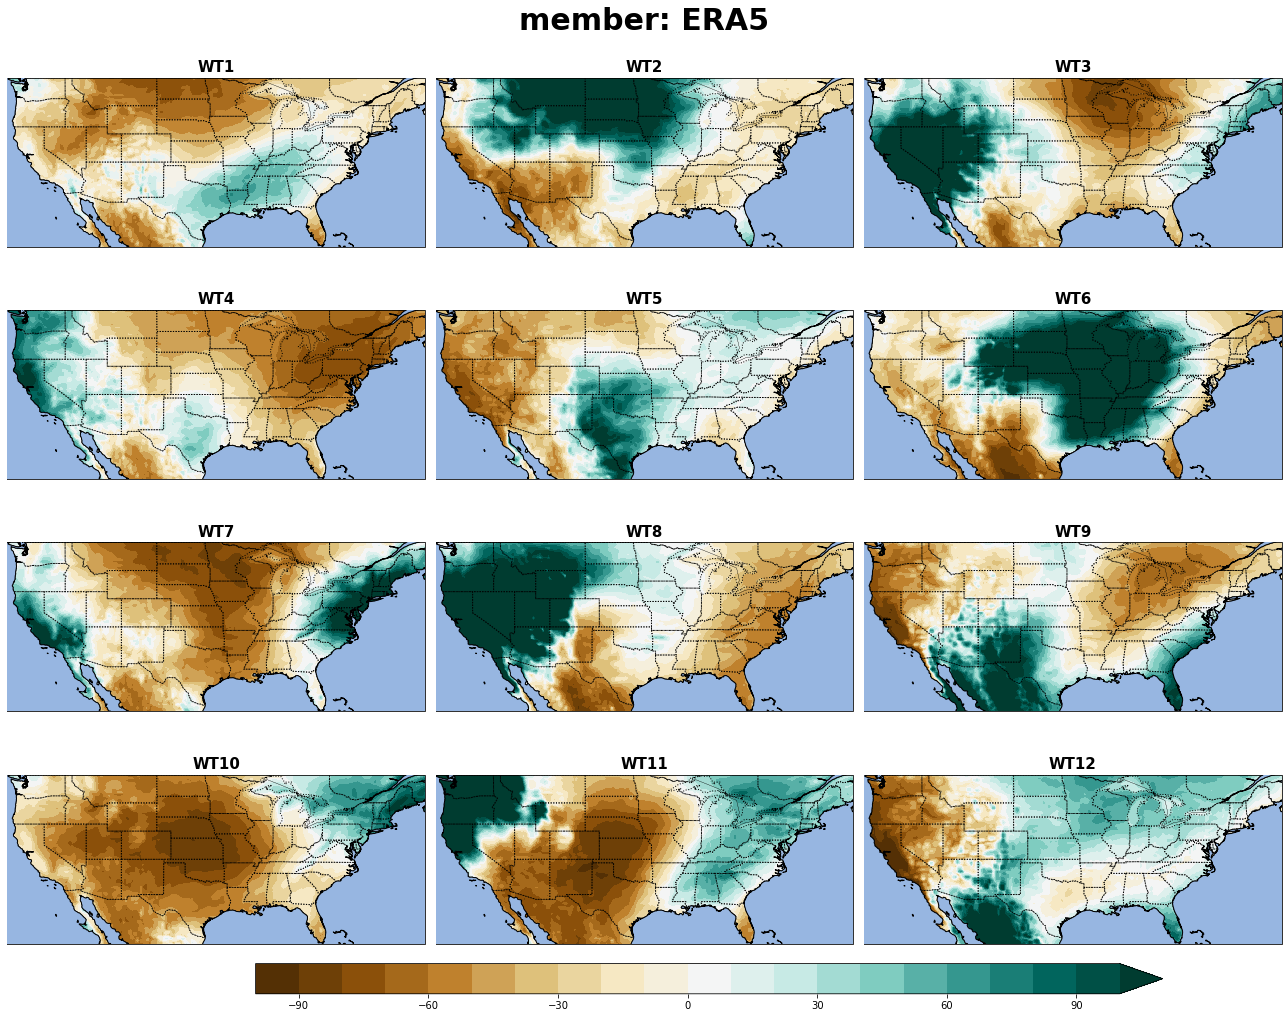

In [23]:
plot_prec_12(prec_xr, -100, 100, 21, 'BrBG', 'horizontal', 'ERA5') 